## Plot statistical 'distance' as a function of truncation point

For the first plot, we will show the performance of the _general_ truncation scheme to recover the full bitstring distribution, as a function of cutoff weight $w$.

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import utils
import response_matrix

In [8]:
# Utilities for making probability distributions

def make_uniform(n):
    """Make the uniform distribution over n qubits."""
    d = 1 << n
    return np.ones(d) / d

def make_random(n):
    d = 1 << n
    out = np.random.rand(d)
    return out / out.sum()


### Compute the corrected prob distribution using Algorithm 1

In [221]:
list(range(8, -1, -2))

[8, 6, 4, 2, 0]

In [226]:
def slice_for_Rj(n, j):
    """Construct an array slice for all indices corresponding to an Rj cut.

    TODO: could be more efficient taking
    Args:
        n: number of bits
        j: "order" of R_j to compute
    Returns:
        slices: tuple(np.ndarray, np.ndarray) of zipped (x,y) corrdinates, such
            that R[slices] = R_j
    """
    out = []
    d = 1 << n
    for i in range(d):
        for k in range(d):
            if k < i:
                continue
            if utils.distance(i, k) == j:
                out.append((i,k))
    out = np.asarray(list(zip(*out)))
    slices = tuple(np.hstack((out, out[::-1,:])))
    return slices




def invert_pfull_truncated(R, p_prime, w1, w2=None):
    """Compute $R^{-1}p'$ using a series truncation.

    Args:
        R: Baseline response matrix.
        p_prime: Probability distribution representing observations WITH errors
        w1: Cutoff for the _infinite_ series for computing A^{-1}
        w2: Cutoff for the decomposition of R into {R_j: j=1, ..., w2}

    Returns:
        p_fixed: output distribution acheived by inverting R up to truncation
            (w1, w2).
    """

    if w2 is None:
        w2 = w1

    d = R.shape[0]
    n = int(np.log2(d))
    out = np.zeros((d, d))

    # Compute the inverse of diagonal of R efficiently
    R0_inv = np.zeros((d, d), dtype=float)
    R0_inv[np.diag_indices(d)] = np.reciprocal(np.diag(R))

    # Initialize series truncation for partitioned R
    S = np.zeros((d, d))
    for j in range(1, w2 + 1):
        Rj = np.zeros((d,d))
        Rj[slice_for_Rj_v2(n, j)] = R[slice_for_Rj_v2(n, j)] 
        S -= R0_inv @ Rj

    # update output distribution
    v = R0_inv.dot(p_prime)
    p_fixed = np.copy(v)
    for k in range(1, w1 + 1):
        v = S.dot(v)
        p_fixed += v

    return p_fixed


### Construct test R

We enforce that $R$ has a tensor structure so that multi-flip events are necessarily exponentially suppressed in weight change of bitstring.

In [10]:
# Arrays of q(0|1) and q(1|0)
q01_arr = [0.09, .07, 0.12, 0.08, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.02]
R = response_matrix.Rmatrix(q01_arr, q10_arr)
Rinv = np.linalg.inv(R)

Text(0.5, 1.0, 'Initial comparison')

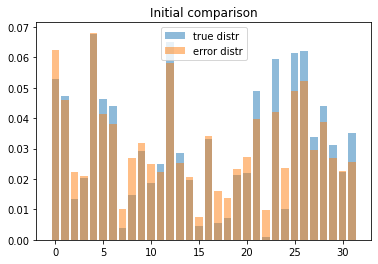

In [11]:
n = len(q01_arr)
x = np.arange(1 << n)
p_true = make_random(n)
p_prime = R @ p_true

plt.bar(x, p_true, alpha=0.5, label="true distr")
plt.bar(x, p_prime, alpha=0.5, label="error distr")
plt.legend()
plt.title("Initial comparison")

In [12]:
def trace_dist(a, b):
    return abs(a - b).sum()

In [237]:
def slice_for_Rj_v2(n, j):
#     """כ'הָב א ביסל מוירע...וי בײ""""
    candidates = list(range(j, -1, -2))
    print(candidates)
    out = []
    d = 1 << n
    for i in range(d):
        for k in range(d):
            if k < i:
                continue
            if utils.distance(i, k) in candidates:
                out.append((i,k))
    out = np.asarray(list(zip(*out)))
    slices = tuple(np.hstack((out, out[::-1,:])))
    return slices


def pfull_truncated(R, p_prime, w1, w2=None):
    """Compute $R^{-1}p'$ using a series truncation.

    Args:
        R: Baseline response matrix.
        p_prime: Probability distribution representing observations WITH errors
        w1: Cutoff for the _infinite_ series for computing A^{-1}
        w2: Cutoff for the decomposition of R into {R_j: j=1, ..., w2}

    Returns:
        p_fixed: output distribution acheived by inverting R up to truncation
            (w1, w2).
    """

    if w2 is None:
        w2 = w1

    d = R.shape[0]
    n = int(np.log2(d))
    # Compute the inverse of diagonal of R efficiently
    Rdiag_inv = np.zeros((d, d), dtype=float)
    Rdiag_inv[np.diag_indices(d)] = np.reciprocal(np.diag(R))
    
    # Initialize series truncation for partitioned R
    S = np.zeros((d, d))
    for j in range(1, w2 + 1):
        Rj = np.zeros((d, d))
        Rj[slice_for_Rj_v2(n, j)] = R[slice_for_Rj_v2(n, j)]
        S -= Rdiag_inv @ Rj
        
    R_trunc_inv = np.zeros((d, d))
    for k in range(0, w1+1):
        R_trunc_inv += np.linalg.matrix_power(S, k) @ Rdiag_inv
    
    return R_trunc_inv @ p_prime

[2, 0]
23.866673911999996


(32, 32)

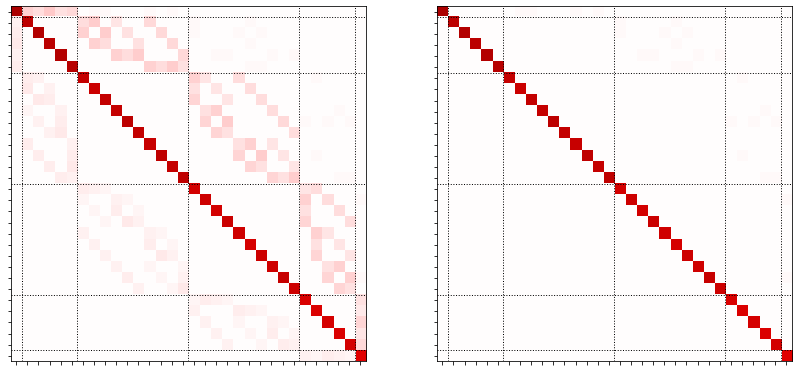

In [238]:
import viz

n = 5
q01_arr = [0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06]
R = response_matrix.Rmatrix(q01_arr[:n], q10_arr[:n])

fig, axes = plt.subplots(1, 2, figsize=(14, 10))
viz.u_imshow(R, n, ax=axes[0], sort_by_weight=True, cmap='seismic', vmin=-1, vmax=1)
R2 = np.zeros((1 << n, 1 << n))
custom_slc = slice_for_Rj_v2(n, 2)
# custom_slc = np.hstack((custom_slc, slice_for_Rj(n, 0)))

R2[custom_slc] = R[custom_slc]
print(R2.sum())
viz.u_imshow(R2, n, ax=axes[1], sort_by_weight=True, cmap='seismic', vmin=-1, vmax=1)

for ax in axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
R.shape

In [244]:
# comparison = lambda x,y: scipy.stats.entropy(x,y)
comparison = lambda x,y: trace_dist(x,y)

q01_arr = [0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06]
# wvals = list(range(1, 5))
# nqubits_lst = list(range(4,8))
wvals = [1, 2, 3, 4]
nqubits_lst = [7]
outcomes = np.zeros((len(wvals) + 1, len(nqubits_lst))) # rows correspond to w=None,1,2...
for j, n_qubits in enumerate(nqubits_lst):
    # Generate response matrix and artificial readout error
    R = response_matrix.Rmatrix(q01_arr[:n_qubits], q10_arr[:n_qubits])
    Rinv = np.linalg.inv(R)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true
    outcomes[0,j] = comparison(p_prime, p_true)
    for k, w in enumerate(wvals):
#         p_fixed = invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        p_fixed = pfull_truncated(R, p_prime, w1=w, w2=w)
        outcomes[k + 1,j] = comparison(p_fixed, p_true)
    

[1]
[1]
[1]
[1]
[2, 0]
[2, 0]
[1]
[1]
[2, 0]
[2, 0]
[3, 1]
[3, 1]
[1]
[1]
[2, 0]
[2, 0]
[3, 1]
[3, 1]
[4, 2, 0]
[4, 2, 0]


In [245]:
outcomes

array([[  0.20537408],
       [  0.15110269],
       [  1.85778429],
       [  8.78029628],
       [106.13711751]])

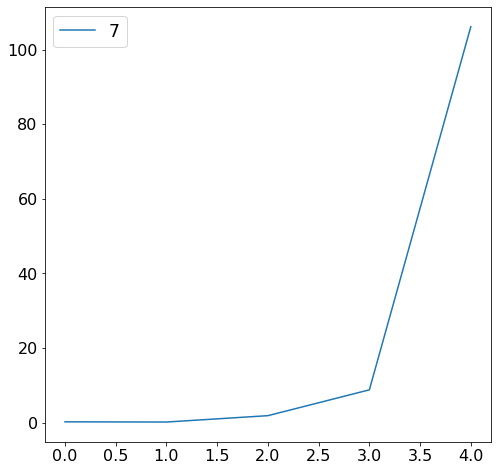

In [246]:
outcomes.shape
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for y, label in zip(outcomes.T, nqubits_lst):
    ax.plot([0]+wvals, y, label=label)
# axes.plot([0] + wvals, outcomes, labels=nqubits_lst)
ax.legend()

In [21]:
outcomes

array([[0.02885234, 0.05485176, 0.08633814, 0.11382901],
       [0.00959164, 0.02866655, 0.06226667, 0.1015916 ],
       [0.08034089, 0.16932734, 0.1854043 , 0.20557381]])

# Visualizing distributions

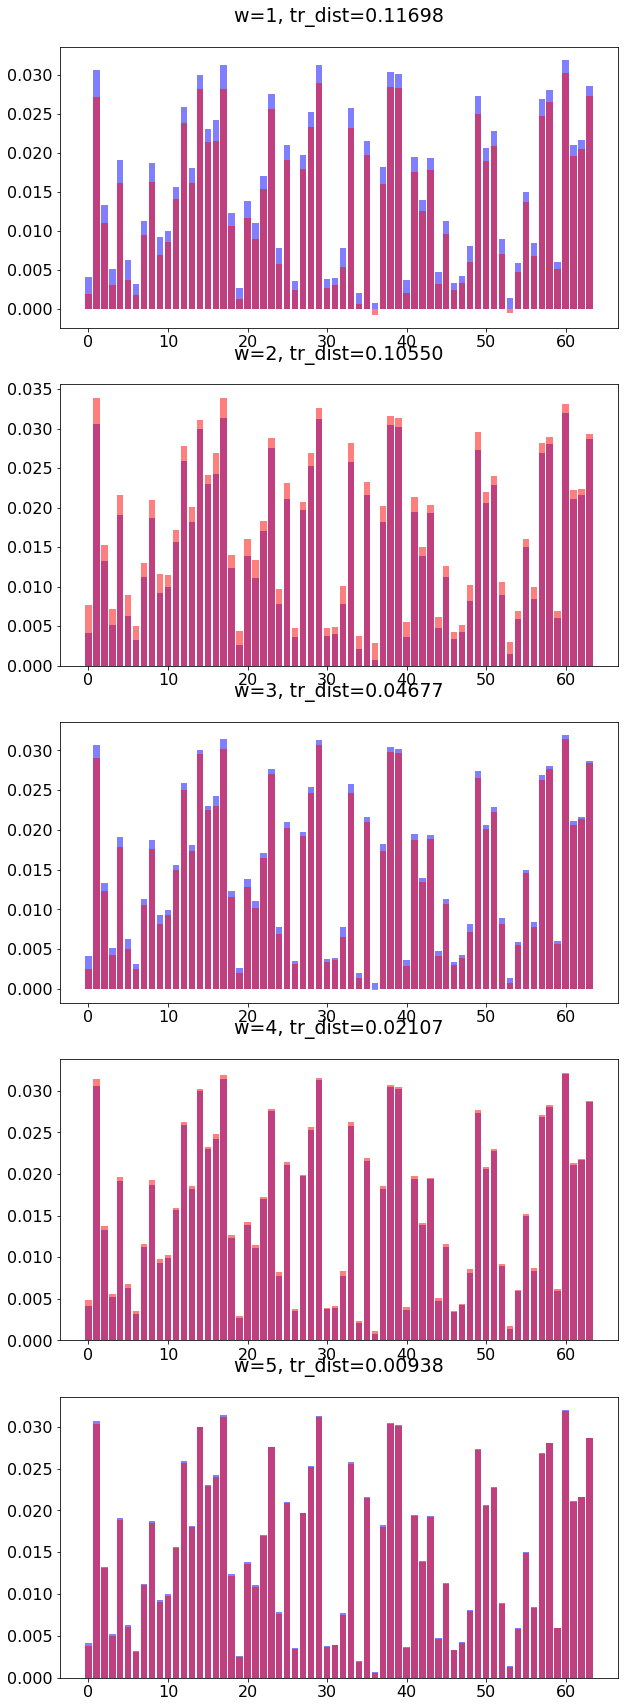

In [161]:
n_qubits = 6
q01_arr = [0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06]
R = response_matrix.Rmatrix(q01_arr[:n_qubits], q10_arr[:n_qubits])
Rinv = np.linalg.inv(R)
p_true = make_random(n_qubits)
p_prime = R @ p_true
x = np.arange(1 << n_qubits)

wvals = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(len(wvals), 1, figsize=(10, 30))
kl_divs = []

for k, w in enumerate(wvals):
    # Empirically i observe that w1,w2 changing independently has little effect on performance
    p_fixed = invert_pfull_truncated(R, p_prime, w1=w, w2=w)
    axes[k].bar(x, p_true, alpha=0.5, label="true distr", color='b')
    axes[k].bar(x, p_fixed, alpha=0.5, label="fixed distr", color='r')
    
    kl_div = trace_dist(p_fixed, p_true)
    axes[k].set_title(f"w={w}, tr_dist={kl_div:3.5f}")
    kl_divs.append(kl_div)
    

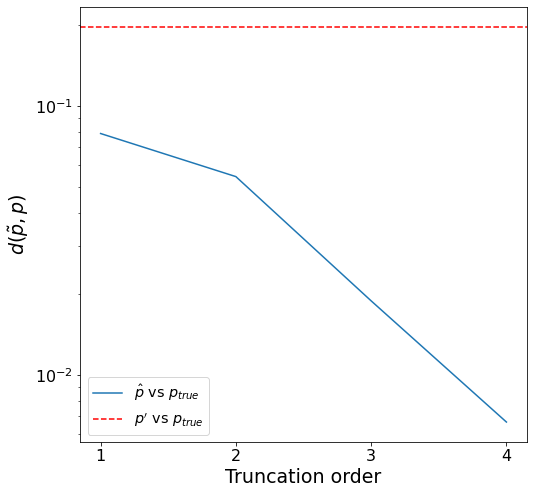

In [17]:
# Plot KL-div as a function of increasing cutoff
plt.style.use('./style.mplstyle')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(wvals, kl_divs, label=r"$\hat{p}$ vs $p_{true}$")

# Compare to no error correction
initial_kl = trace_dist(p_prime, p_true)
ax.axhline(initial_kl, ls='--', c='r', label=r"$p'$ vs $p_{true}$")

# ax.set_title("KL_div vs. cutoff w")
ax.semilogy()
ax.set_xlabel(r"Truncation order")
ax.set_ylabel(r"$d(p, \tilde{p})$")
ax.set_xticks(wvals)
ax.legend(prop={'size': 'x-large'})

None

In [112]:
fig.savefig("figure1.pdf")